In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from categorical import one_hot_encode_categorical
from feature_nlp import nlp
from feature_numerical import process_numerical_columns
from location_preprocessing import get_locations_features
from feature_date import cyclical_encode_dates
from parse_amenities import parse_amenities

import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [3]:
df = pd.read_csv("Airbnb_Data.csv")
df.set_index('id', inplace=True)

In [4]:
# Filter out Parking Space and Lighthouse, as they only contain one instance
condition = ~df['property_type'].isin(['Parking Space', 'Lighthouse'])

df = df[condition]
df.shape

(74109, 28)

In [5]:
df_amenities_count = parse_amenities(df)

In [6]:
df_categorical = one_hot_encode_categorical(df)

/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [7]:
df_nlp = nlp(df)

In [8]:
df_numerical = process_numerical_columns(df)

Filling NAs


/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(

False


/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.21632368274488525, -0.22401526463951021, -0.27704117297049535, -0.5504049973617441, -0.6606857706718918, -0.29464905443971723, -0.03504170422841744, -0.05259463602601694, -0.03617848617245744, -0.016011843030901172, -0.032233679695850344, -0.012724922514405015, -0.07474199641712549, -0.005194927862790968, -0.09139235070358351, -0.03817476754321505, -0.01722962653384052, -0.020779711451163873, -0.024366371518780607, -0.003673368719554432, -0.032023686061802344, -0.006362461257202507, -0.008213902163345072, -0.025974639313954842, -0.1100785478616123, -0.03181230628601253, -0.007346737439108864, -0.03159951255138711, -0.06319902510277423, -0.012183185759390303, -0.023232423678816613, -0.02264416557288956, -0.03073360770371854, -0.022940180300996718, -0.03887528042313918, -0.01836684359777216, -0.03939249092437684, -0.052337448000

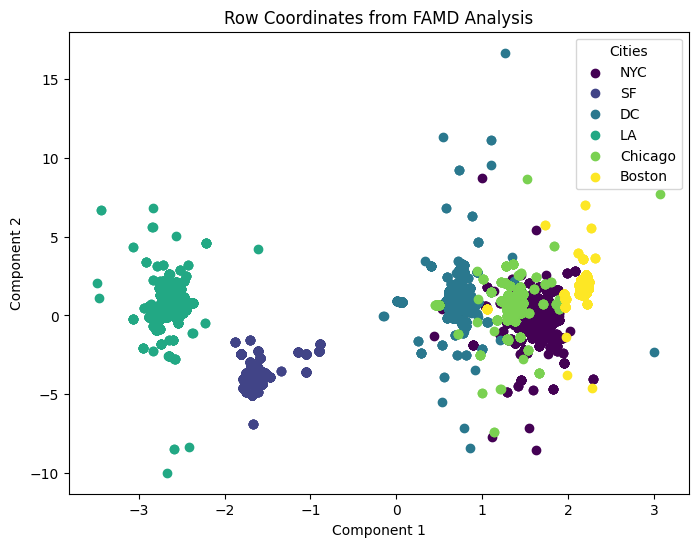

In [9]:
df_locations = get_locations_features(df)

In [10]:
df_datetime = cyclical_encode_dates(df)

Missing rows in first_review: 15862
Missing rows in host_since: 188
Missing rows in last_review: 15825


/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
/Users/ChanWingYiu

df_amenities_count = parse_amenities(df)
df_categorical = one_hot_encode_categorical(df)
df_nlp = nlp(df)
df_numerical = process_numerical_columns(df)
df_locations = get_locations_features(df)
df_datetime = cyclical_encode_dates(df)

In [11]:
all_data_df = pd.concat([
    df['log_price'],
    df_amenities_count,
    df_categorical[[
        'property_type', 'room_type', 'bed_type', 'cancellation_policy',
        'cleaning_fee', 'host_identity_verified',
        'instant_bookable']],
    df_nlp[['description_polarity', 'description_subjectivity']],
    df_numerical[['accommodates', 'beds_per_bedroom',
                  'bed_and_bathrooms', 'review_scores_rating_normalized', 'number_of_reviews']],
    df_locations[['location_component_0', 'location_component_1', 'city']],
    df_datetime[['first_review_days_since', 'host_since_days_since']]

], axis=1)

In [12]:
print(all_data_df.shape)
print(all_data_df.dtypes)

(74109, 21)
log_price                          float64
amenities_count                    float64
property_type                      float64
room_type                          float64
bed_type                           float64
cancellation_policy                float64
cleaning_fee                        object
host_identity_verified              object
instant_bookable                    object
description_polarity               float64
description_subjectivity           float64
accommodates                         int64
beds_per_bedroom                   float64
bed_and_bathrooms                  float64
review_scores_rating_normalized    float64
number_of_reviews                    int64
location_component_0               float64
location_component_1               float64
city                                object
first_review_days_since            float64
host_since_days_since              float64
dtype: object


In [13]:
all_data_df.columns[all_data_df.isna().any()].tolist()

[]

In [14]:
X = all_data_df.drop(['log_price', 'city'], axis=1).copy()
X = X.apply(pd.to_numeric)
# Convert boolean columns to integers if there are any
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

y = all_data_df['log_price'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [15]:
X_train_tensor = torch.tensor(X_train.astype(np.float32).values)
y_train_tensor = torch.tensor(y_train.astype(np.float32).values)
X_test_tensor = torch.tensor(X_test.astype(np.float32).values)
y_test_tensor = torch.tensor(y_test.astype(np.float32).values)

In [16]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [17]:
# Neural network architecture here
class RegressionNN(nn.Module):
    def __init__(self, num_features):
        super(RegressionNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 128) # Input layer
        self.layer2 = nn.Linear(128, 64)           # Hidden layer
        self.layer3 = nn.Linear(64, 1)             # Output layer
        self.relu = nn.ReLU()                      # Activation function
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [18]:
num_features = X_train.shape[1]
model = RegressionNN(num_features)

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.4475
Epoch [2/100], Loss: 0.2533
Epoch [3/100], Loss: 0.2061
Epoch [4/100], Loss: 0.1844
Epoch [5/100], Loss: 0.2523
Epoch [6/100], Loss: 0.1964
Epoch [7/100], Loss: 0.3304
Epoch [8/100], Loss: 0.3597
Epoch [9/100], Loss: 0.0622
Epoch [10/100], Loss: 0.1386
Epoch [11/100], Loss: 0.1567
Epoch [12/100], Loss: 0.0995
Epoch [13/100], Loss: 0.1595
Epoch [14/100], Loss: 0.5278
Epoch [15/100], Loss: 0.1914
Epoch [16/100], Loss: 0.1122
Epoch [17/100], Loss: 0.3311
Epoch [18/100], Loss: 0.1123
Epoch [19/100], Loss: 0.3158
Epoch [20/100], Loss: 0.1970
Epoch [21/100], Loss: 0.2532
Epoch [22/100], Loss: 0.1874
Epoch [23/100], Loss: 0.1449
Epoch [24/100], Loss: 0.2166
Epoch [25/100], Loss: 0.1023
Epoch [26/100], Loss: 0.3387
Epoch [27/100], Loss: 0.2427
Epoch [28/100], Loss: 0.1825
Epoch [29/100], Loss: 0.1986
Epoch [30/100], Loss: 0.2292
Epoch [31/100], Loss: 0.1600
Epoch [32/100], Loss: 0.1081
Epoch [33/100], Loss: 0.1349
Epoch [34/100], Loss: 0.1780
Epoch [35/100], Loss: 0

In [21]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    mse = criterion(predictions, y_test_tensor)
    print(f'Test MSE: {mse.item()}')

Test MSE: 0.2139982283115387


In [22]:
SS_res = torch.sum((y_test_tensor - predictions) ** 2)
SS_tot = torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2)

r_squared = 1 - (SS_res / SS_tot)
print(f'R-squared: {r_squared.item()}')

R-squared: 0.5838335752487183


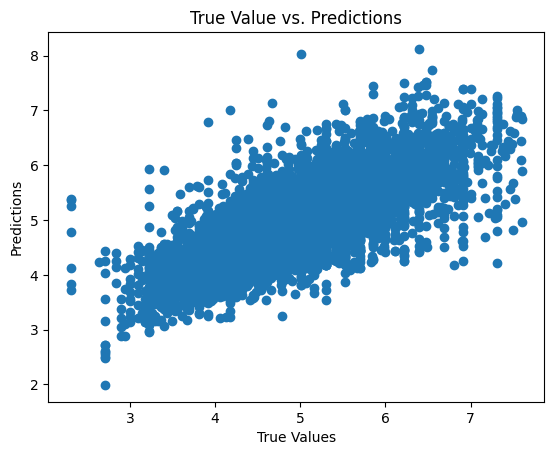

In [23]:
plt.scatter(y_test_tensor, predictions.numpy())
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Value vs. Predictions')
#plt.savefig('plot.png')
plt.show()